In [2]:
#import necessary libraries
import requests
import json
import tweepy
import pandas as pd
import numpy as np
import os
from datetime import datetime
import json
import matplotlib.pyplot as plt
% matplotlib inline

## Gather Data

In [95]:
# download the WeRateDogs Twitter archive manually
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [6]:
# programmatically download image_predictions.tsv from url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
#response = requests.get(url).content
#with open('image_predictions.tsv', 'wb') as file:
    #file.write(response.content)

image = pd.read_csv(url, sep = '\t')
image.to_csv('image_predictions.tsv', sep = '\t')

In [7]:
# Use tweet IDs in archive to query Twitter API for JSON data of: retweet count, favorite count, comment count
consumer_key = 'CONSUMER KEY'
consumer_secret = 'CONSUMER SECRET'
access_token = 'ACCESS TOKEN'
access_token_secret = 'TOKEN SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
user = api.get_user('dog_rates')

print (user.screen_name)
print (user.followers_count)

dog_rates
5729831


In [8]:
#let's take a look at a tweets data dictionary to identify what else we can query
import pprint

tweet1 = str(api.get_status(archive['tweet_id'][0], tweet_mode='extended'))
pp = pprint.PrettyPrinter(indent=10)
pp.pprint(tweet1)

("Status(_api=<tweepy.api.API object at 0x112c52278>, _json={'created_at': "
 "'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': "
 '\'892420643555336193\', \'full_text\': "This is Phineas. He\'s a mystical '
 'boy. Only ever appears in the hole of a donut. 13/10 '
 'https://t.co/MgUWQ76dJU", \'truncated\': False, \'display_text_range\': [0, '
 "85], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], "
 "'urls': [], 'media': [{'id': 892420639486877696, 'id_str': "
 "'892420639486877696', 'indices': [86, 109], 'media_url': "
 "'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': "
 "'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': "
 "'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', "
 "'expanded_url': "
 "'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': "
 "'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, "
 "'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'sm

In [9]:
# list of dictionaries of desired info from tweets to build and convert to a DataFrame
#record start time of running code 
start_time = datetime.now() 

tweet_data = []
tweet_errors = []

with open('tweet_json.txt', 'w') as file:
    for tweet_id in archive['tweet_id']:
        try:
            #query each tweet for which there is a matching tweet_id in archive
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            twt_id = tweet._json['id']
            retweet_count = tweet._json['retweet_count']
            favorite_count = tweet._json['favorite_count']
            is_quote = tweet._json['is_quote_status']
            #add all queried data to tweet_data
            tweet_data.append({'tweet_id': twt_id,
                                    'retweet_count': retweet_count,
                                    'favorite_count': favorite_count,
                                    'is_quote_status': is_quote,})
        except tweepy.TweepError: #deal with tweets that bring up errors, i.e. are no longer there
            tweet_errors.append(tweet_id)
            continue
    json.dump(tweet_data, file)

#record time elapsed for code to run
time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Rate limit reached. Sleeping for: 724
Rate limit reached. Sleeping for: 736
Time elapsed (hh:mm:ss.ms) 0:41:46.408393


In [10]:
#with open('tweet_json.txt', 'r') as fp:
tweet_data = pd.DataFrame(tweet_data, columns = ['tweet_id','retweet_count','favorite_count','is_quote_status'])

## Assess Data

In [96]:
#set up display widths for better assessing
pd.set_option('display.max_colwidth', 140)
archive['expanded_urls'] = archive['expanded_urls'].str[:20]
archive['source'] = archive['source'].str[:20]

In [97]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twit",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twit","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/...",NaN,NaN,NaN,https://twitter.com/,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twit",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/w...,NaN,NaN,NaN,https://twitter.com/,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twit",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twit","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWe...",NaN,NaN,NaN,https://twitter.com/,12,10,Franklin,None,None,None,None


In [98]:
print(archive.info())
archive.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [99]:
#tweets that are replies or retweets
archive.query('in_reply_to_status_id.notnull() | retweeted_status_id.notnull()')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twit",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/,13,10,Canela,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twit",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twit",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twit",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/,13,10,Lilly,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twit",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twit",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twit",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twit","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nht...",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,https://www.gofundme,13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twit",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.c...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twit",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/,14,10,None,None,None,pupper,None


In [100]:
archive[archive['rating_numerator'] <= 5]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twit","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,https://twitter.com/,5,10,Bella,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twit",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,https://twitter.com/,0,10,None,None,None,None,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twit",RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t....,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/,1,10,None,None,None,None,None
730,781661882474196992,NaN,NaN,2016-09-30 01:08:10 +0000,"<a href=""http://twit",Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,NaN,NaN,NaN,https://twitter.com/,5,10,None,None,None,None,None
765,777885040357281792,NaN,NaN,2016-09-19 15:00:20 +0000,"<a href=""http://twit",This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbM...,NaN,NaN,NaN,https://twitter.com/,3,10,Wesley,None,None,None,None
883,760252756032651264,NaN,NaN,2016-08-01 23:15:56 +0000,"<a href=""http://twit",This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q...,NaN,NaN,NaN,https://twitter.com/,4,10,Fido,None,None,None,None
912,757596066325864448,NaN,NaN,2016-07-25 15:19:12 +0000,"<a href=""http://twit",Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL1...,NaN,NaN,NaN,https://twitter.com/,4,10,None,None,None,None,None
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twit",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,NaN,NaN,NaN,https://twitter.com/,5,10,None,doggo,None,pupper,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twit",Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,NaN,NaN,NaN,https://twitter.com/,4,10,a,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twit","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",NaN,NaN,NaN,https://twitter.com/,0,10,None,None,None,None,None


In [101]:
archive.query('tweet_id == 883482846933004288 | tweet_id == 695064344191721472 | tweet_id == 691483041324204033')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twit","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,https://twitter.com/,5,10,Bella,None,None,None,None
1459,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,"<a href=""http://twit","This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",NaN,NaN,NaN,https://twitter.com/,4,10,None,None,None,None,None
1508,691483041324204033,NaN,NaN,2016-01-25 04:49:38 +0000,"<a href=""http://twit",When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/ae...,NaN,NaN,NaN,https://twitter.com/,5,10,None,None,None,None,None


In [102]:
#tweets that don't match up with rating denominator of 10
archive.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twit","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twit",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twit",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,https://twitter.com/,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twit",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/9...,NaN,NaN,NaN,https://www.gofundme,24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twit","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP http...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twit",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twit","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDND...",NaN,NaN,NaN,https://twitter.com/,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twit",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twit",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twit",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/,50,50,Bluebert,None,None,None,None


In [103]:
#number of tweets with no dog name mentioned
archive[archive['name'] == 'None'].shape

(745, 17)

In [104]:
#example of a tweet with no dog name mentioned
archive.iloc[5]['text']

"Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh"

In [105]:
#search for tweets with more than one "dog category" label
archive.query('doggo == "doggo" & floofer == "floofer" & pupper == "None" & puppo == "None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twit","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send ...",NaN,NaN,NaN,https://twitter.com/,11,10,None,doggo,floofer,None,None


In [106]:
archive.query('doggo == "doggo" & floofer == "None" & pupper == "pupper" & puppo == "None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twit","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodo...",NaN,NaN,NaN,https://twitter.com/,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twit",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/AN...,NaN,NaN,NaN,https://twitter.com/,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twit","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twit",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55...,NaN,NaN,NaN,https://twitter.com/,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twit",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautio...,NaN,NaN,NaN,https://twitter.com/,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5r,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twit","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twit",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/,12,10,just,doggo,None,pupper,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twit","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MY...",NaN,NaN,NaN,https://twitter.com/,12,10,Maggie,doggo,None,pupper,None
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twit",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,NaN,NaN,NaN,https://twitter.com/,5,10,None,doggo,None,pupper,None


In [107]:
#investigate max value for rating numerator from describe table
archive[archive['rating_numerator'] == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://abo",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/,1776,10,Atticus,None,None,None,None


In [108]:
#investigate text of tweets that have what seem to be inaccurate ratings
#1:
print("1:{}".format(archive.iloc[516]['text']))
#2:
print("2:{}".format(archive.iloc[1068]['text']))
#3:
print("3:{}".format(archive.iloc[1165]['text']))
#4:
print("4:{}".format(archive.iloc[1202]['text']))
#5:
print("5:{}".format(archive.iloc[1662]['text']))
#6:
print("6:{}".format(archive.iloc[2335]['text']))

1:Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
2:After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
3:Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
4:This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
5:This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
6:This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


In [109]:
#investigate text of tweets that have what seem to be group ratings
#1:
print("1:{}".format(archive.iloc[433]['text']))
#2:
print("2:{}".format(archive.iloc[902]['text']))
#3:
print("3:{}".format(archive.iloc[1120]['text']))
#4:
print("4:{}".format(archive.iloc[1228]['text']))
#5:
print("5:{}".format(archive.iloc[1254]['text']))
#6:
print("6:{}".format(archive.iloc[1274]['text']))
#7:
print("7:{}".format(archive.iloc[1351]['text']))
#8:
print("8:{}".format(archive.iloc[1433]['text']))
#9:
print("9:{}".format(archive.iloc[1635]['text']))
#10:
print("10:{}".format(archive.iloc[1779]['text']))
#11:
print("11:{}".format(archive.iloc[1843]['text']))

1:The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
2:Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
3:Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
4:Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
5:Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
6:From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
7:Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
8:Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
9:Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
10:IT'S PUPPERGE

In [110]:
archive[archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [111]:
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [112]:
print(image.info())
image.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None


,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [113]:
#image predictions that aren't of dogs
image.query('p1_dog == False & p2_dog == False & p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


In [114]:
tweet_data.head()

,tweet_id,retweet_count,favorite_count,is_quote_status
0,892420643555336193,8698,39116,False
1,892177421306343426,6383,33495,False
2,891815181378084864,4241,25244,False
3,891689557279858688,8798,42474,False
4,891327558926688256,9577,40635,False


In [115]:
print(tweet_data.info())
tweet_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 4 columns):
tweet_id           2346 non-null int64
retweet_count      2346 non-null int64
favorite_count     2346 non-null int64
is_quote_status    2346 non-null bool
dtypes: bool(1), int64(3)
memory usage: 57.4 KB
None


,tweet_id,retweet_count,favorite_count
count,2.346000e+03,2346.000000,2346.000000
mean,7.423380e+17,3065.364450,8116.495737
std,6.835504e+16,5089.920444,12200.732689
min,6.660209e+17,0.000000,0.000000
25%,6.783824e+17,612.250000,1410.250000
50%,7.189556e+17,1434.000000,3565.000000
75%,7.987010e+17,3574.750000,10049.250000
max,8.924206e+17,78212.000000,144168.000000


In [116]:
print(tweet_data.query('retweet_count == 0'))
archive.query('tweet_id == 838085839343206401')

               tweet_id  retweet_count  favorite_count  is_quote_status
285  838085839343206401              0             148            False


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twit",@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None


In [117]:
tweet_data[tweet_data.tweet_id.duplicated()]

,tweet_id,retweet_count,favorite_count,is_quote_status


### Quality

#### `archive` table

- Some tweets appear to have assigned two or more dog categories ('doggo', 'pupper', 'floofer', 'puppo')
- Rating denominators sometimes not equal to 10
- Observations in rows 433, 902, 1120, 1228, 1254, 1274, 1351, 1433, 1635, 1779, 1843 are ratings of a group of dogs, they should be ratings of only one dog
- Erroneous datatypes (tweet_id, dog category, timestamp)
- Timestamp column includes the UTC timezone when it is consistent for the whole dataset
- Dogs not categorized in doggo, floofer, pupper and puppo column have 'None' instead of NaN
- Dogs without names in name column have 'None' instead of NaN
- Observations in rows 45, 516, 1068, 1165, 1202, 1459, 1508, 1662, and 2335 have inaccurate ratings

#### `image` table
- Erroneous datatype(tweet_id)

#### `tweet_data` table
- Erroneous datatype(tweet_id)


### Tidiness

- Remove all observations in `archive` table that are not original ratings (i.e. retweets, replies) with images
- Bring the 1 variable in 4 columns in `archive` table (doggo, floofer, pupper and puppo) into one column
- `tweet_data` and `image` should be a part of `archive` table

## Clean Data

In [118]:
#make copy of all three tables
archive_clean = archive.copy()
image_clean = image.copy()
tweet_data_clean = tweet_data.copy()

### Tidiness

#### Not all observations are original ratings, some are replies and some are retweets

#### *Define*

Identify all rows that are either retweets or replies, and drop them from the table. Then drop columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

#### *Code*

In [119]:
archive_clean = archive_clean.query('in_reply_to_status_id.isnull() & retweeted_status_id.isnull()')

#### *Test*

In [120]:
archive_clean.query('in_reply_to_status_id.notnull() & retweeted_status_id.notnull()')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [121]:
#remove those columns now that not needed
archive_clean = archive_clean.drop(columns = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'])

Let's quickly check how many rows have no dog category before moving to next step.

In [122]:
len(archive_clean.query('doggo == "None" & floofer == "None" & pupper == "None" & puppo == "None"'))

1761

#### 1 variable is in 4 columns in `archive` table (doggo, floofer, pupper and puppo)

#### *Define*

Bring the 1 variable in 4 columns in `archive` table (doggo, floofer, pupper and puppo) into one column by concatenating all into one new column, and cleaning from there. We are looking for a value of 1761 in value counts for 'None' dog type.

#### *Code*

In [123]:
#create new 'category' column
archive_clean['category'] = archive_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: '{},{},{},{}'.format(x[0],x[1],x[2],x[3]), axis=1)

#split values at ',' and remove duplicate 'None' values
archive_clean['category'] = archive_clean['category'].str.split(',').apply(set)

In [124]:
#remove 'None' if more than one category
def remove_none(cell):
    if len(cell) > 1:
        cell.remove('None')
    return list(cell)

archive_clean['category'] = archive_clean['category'].apply(remove_none)

In [125]:
#drop original columns
archive_clean = archive_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1)

#### *Test*

In [126]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twit",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/,13,10,Phineas,[None]
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twit","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/...",https://twitter.com/,13,10,Tilly,[None]
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twit",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/w...,https://twitter.com/,12,10,Archie,[None]
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twit",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/,13,10,Darla,[None]
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twit","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWe...",https://twitter.com/,12,10,Franklin,[None]


### Quality

#### Some tweets appear to have assigned two or more dog categories ('doggo', 'pupper', 'floofer', 'puppo')

#### *Define*

Identify which tweets these are and either manually or programmatically go through each of them to make corrections

#### *Code*

In [127]:
#pull up all tweets assigned to more than one category
archive_clean[archive_clean['category'].apply(len) > 1]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category
191,855851453814013952,2017-04-22 18:31:02 +0000,"<a href=""http://twit",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for h...,https://twitter.com/,13,10,None,"[puppo, doggo]"
200,854010172552949760,2017-04-17 16:34:26 +0000,"<a href=""http://twit","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send ...",https://twitter.com/,11,10,None,"[floofer, doggo]"
460,817777686764523521,2017-01-07 16:59:28 +0000,"<a href=""http://twit","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodo...",https://twitter.com/,13,10,Dido,"[pupper, doggo]"
531,808106460588765185,2016-12-12 00:29:28 +0000,"<a href=""http://twit",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/AN...,https://twitter.com/,12,10,None,"[pupper, doggo]"
575,801115127852503040,2016-11-22 17:28:25 +0000,"<a href=""http://twit",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55...,https://twitter.com/,12,10,Bones,"[pupper, doggo]"
705,785639753186217984,2016-10-11 00:34:48 +0000,"<a href=""http://twit",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautio...,https://twitter.com/,10,10,Pinot,"[pupper, doggo]"
733,781308096455073793,2016-09-29 01:42:20 +0000,"<a href=""http://vine","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",https://vine.co/v/5r,12,10,None,"[pupper, doggo]"
889,759793422261743616,2016-07-31 16:50:42 +0000,"<a href=""http://twit","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MY...",https://twitter.com/,12,10,Maggie,"[pupper, doggo]"
956,751583847268179968,2016-07-09 01:08:47 +0000,"<a href=""http://twit",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,https://twitter.com/,5,10,None,"[pupper, doggo]"
1063,741067306818797568,2016-06-10 00:39:48 +0000,"<a href=""http://twit",This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,https://twitter.com/,12,10,just,"[pupper, doggo]"


In [128]:
#deal with each of the multi-categorized tweets above
archive_clean.loc[archive_clean['tweet_id'] == 855851453814013952,'category'] = 'puppo'
archive_clean.loc[archive_clean['tweet_id'] == 854010172552949760,'category'] = 'doggo'
archive_clean.loc[archive_clean['tweet_id'] == 817777686764523521,'category'] = 'pupper'
archive_clean.loc[archive_clean['tweet_id'] == 801115127852503040,'category'] = 'pupper'
archive_clean.loc[archive_clean['tweet_id'] == 785639753186217984,'category'] = 'doggo'
archive_clean.loc[archive_clean['tweet_id'] == 751583847268179968,'category'] = 'None'

# tweet_ids 808106460588765185, 781308096455073793, 759793422261743616, 741067306818797568, 733109485275860992
# are multi dog tweets - move to group dogs

#### *Test*

In [129]:
archive_clean[archive_clean['category'].apply(len) == 2]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category
531,808106460588765185,2016-12-12 00:29:28 +0000,"<a href=""http://twit",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/AN...,https://twitter.com/,12,10,None,"[pupper, doggo]"
733,781308096455073793,2016-09-29 01:42:20 +0000,"<a href=""http://vine","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",https://vine.co/v/5r,12,10,None,"[pupper, doggo]"
889,759793422261743616,2016-07-31 16:50:42 +0000,"<a href=""http://twit","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MY...",https://twitter.com/,12,10,Maggie,"[pupper, doggo]"
1063,741067306818797568,2016-06-10 00:39:48 +0000,"<a href=""http://twit",This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,https://twitter.com/,12,10,just,"[pupper, doggo]"
1113,733109485275860992,2016-05-19 01:38:16 +0000,"<a href=""http://twit","Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",https://twitter.com/,12,10,None,"[pupper, doggo]"


Only group ratings are left, which are addressed next.

#### Rating denominators sometimes not equal to 10

#### Observations in 16 rows are ratings of a group of dogs, they should be ratings of only one dog

#### *Define* 

For each tweet that adds up all the scores, divide the current rating by number of dogs referred to in tweet and replace that value in the table. Then duplicate each tweet to match the number of dogs referred to in the tweet to make sure there is an observation for each dog. For each tweet that applies individual score for the group, duplicate rating in new row copying the correct data about which dog from the tweet is in which row.

#### *Code*

In [130]:
## tweet_ids 808106460588765185, 781308096455073793, 759793422261743616, 741067306818797568, 733109485275860992
archive_clean.loc[archive_clean['tweet_id'] == 808106460588765185,['name','category']] = ['Burke','pupper']
archive_clean = archive_clean.append(archive_clean.loc[archive_clean['tweet_id'] == 808106460588765185], ignore_index=True)
archive_clean.loc[2097,['name','category']] = ['Dexter','doggo']

In [131]:
archive_clean.loc[archive_clean['tweet_id'] == 781308096455073793,'category'] = 'pupper'
archive_clean = archive_clean.append(archive_clean.loc[archive_clean['tweet_id'] == 781308096455073793], ignore_index=True)
archive_clean.loc[2098,'category'] = 'doggo'

In [132]:
archive_clean.loc[archive_clean['tweet_id'] == 759793422261743616,'category'] = 'doggo'
archive_clean = archive_clean.append(archive_clean.loc[archive_clean['tweet_id'] == 759793422261743616], ignore_index=True)
archive_clean.loc[2099,['name','category']] = ['Lila','pupper']

In [133]:
archive_clean.loc[archive_clean['tweet_id'] == 741067306818797568,['name','category']] = ['None','doggo']
archive_clean = archive_clean.append(archive_clean.loc[archive_clean['tweet_id'] == 741067306818797568], ignore_index=True)
archive_clean.loc[2100,'category'] = 'pupper'

In [134]:
archive_clean.loc[archive_clean['tweet_id'] == 733109485275860992,'category'] = 'doggo'
archive_clean = archive_clean.append(archive_clean.loc[archive_clean['tweet_id'] == 733109485275860992], ignore_index=True)
archive_clean.loc[2101,'category'] = 'pupper'

In [135]:
#### row 433, tweet_id 820690176645140481 has about 7 floofers
archive_clean.loc[archive_clean['tweet_id'] == 820690176645140481,['rating_numerator','rating_denominator','category']] = [84/7, 70/7, 'floofer']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 820690176645140481]]*6, ignore_index=True)

#row 902, tweet_id 820690176645140481 has about 15 dogs
archive_clean.loc[archive_clean['tweet_id'] == 758467244762497024,['rating_numerator','rating_denominator']] = [165/15, 150/15]
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 758467244762497024]]*14, ignore_index=True)

#row 1120, tweet_id 731156023742988288 has about 17 doggos
archive_clean.loc[archive_clean['tweet_id'] == 731156023742988288,['rating_numerator','rating_denominator','category']] = [204/17, 170/17,'doggo']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 731156023742988288]]*16, ignore_index=True)

#row 1228, tweet_id 713900603437621249 has 9 puppers
archive_clean.loc[archive_clean['tweet_id'] == 713900603437621249,['rating_numerator','rating_denominator','category']] = [99/9, 90/9,'pupper']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 713900603437621249]]*8, ignore_index=True)

#row 1254, tweet_id 710658690886586372 has 8 puppers
archive_clean.loc[archive_clean['tweet_id'] == 710658690886586372,['rating_numerator','rating_denominator','category']] = [80/8, 80/8, 'pupper']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 710658690886586372]]*7, ignore_index=True)

#row 1351, tweet_id 704054845121142784 has about 5 puppers
archive_clean.loc[archive_clean['tweet_id'] == 704054845121142784,['rating_numerator','rating_denominator','category']] = [60/5, 50/5, 'pupper']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 704054845121142784]]*4, ignore_index=True)

#row 1433, tweet_id 697463031882764288 has 4 pups
archive_clean.loc[archive_clean['tweet_id'] == 697463031882764288,['rating_numerator','rating_denominator']] = [44/4, 40/4]
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 697463031882764288]]*3, ignore_index=True)

#row 1635, tweet_id 684222868335505415 has about 11 puppers
archive_clean.loc[archive_clean['tweet_id'] == 684222868335505415,['rating_numerator','rating_denominator','category']] = [121/11, 110/11, 'pupper']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 684222868335505415]]*10, ignore_index=True)

#row 1779, tweet_id 677716515794329600 has about 12 puppers
archive_clean.loc[archive_clean['tweet_id'] == 677716515794329600,['rating_numerator','rating_denominator','category']] = [144/12, 120/12, 'pupper']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 677716515794329600]]*11, ignore_index=True)

#row 1843, tweet_id 675853064436391936 has about 8 puppers
archive_clean.loc[archive_clean['tweet_id'] == 675853064436391936,['rating_numerator','rating_denominator','category']] = [88/8, 80/8, 'pupper']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 675853064436391936]]*7, ignore_index=True)

#row 1274, tweet_id 709198395643068416 has 5 dogs: Cletus, Jerome, Alejandro, Burp, & Titson
archive_clean.loc[archive_clean['tweet_id'] == 709198395643068416,['rating_numerator','rating_denominator','name']] = [45/5, 50/5, 'Cletus']
archive_clean = archive_clean.append([archive_clean.loc[archive_clean['tweet_id'] == 709198395643068416]]*4, ignore_index=True)
archive_clean.loc[2188,'name'] = 'Jerome'
archive_clean.loc[2189,'name'] = 'Alejandro'
archive_clean.loc[2190,'name'] = 'Burp'
archive_clean.loc[2191,'name'] = 'Titson'

#### *Test*

In [136]:
archive_clean[archive_clean.tweet_id.duplicated()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category
2097,808106460588765185,2016-12-12 00:29:28 +0000,"<a href=""http://twit",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/AN...,https://twitter.com/,12.0,10.0,Dexter,doggo
2098,781308096455073793,2016-09-29 01:42:20 +0000,"<a href=""http://vine","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",https://vine.co/v/5r,12.0,10.0,None,doggo
2099,759793422261743616,2016-07-31 16:50:42 +0000,"<a href=""http://twit","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MY...",https://twitter.com/,12.0,10.0,Lila,pupper
2100,741067306818797568,2016-06-10 00:39:48 +0000,"<a href=""http://twit",This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,https://twitter.com/,12.0,10.0,None,pupper
2101,733109485275860992,2016-05-19 01:38:16 +0000,"<a href=""http://twit","Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",https://twitter.com/,12.0,10.0,None,pupper
2102,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twit",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,https://twitter.com/,12.0,10.0,None,floofer
2103,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twit",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,https://twitter.com/,12.0,10.0,None,floofer
2104,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twit",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,https://twitter.com/,12.0,10.0,None,floofer
2105,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twit",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,https://twitter.com/,12.0,10.0,None,floofer
2106,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twit",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,https://twitter.com/,12.0,10.0,None,floofer


#### Erroneous datatypes (tweet_id, category, timestamp) in `archive` table

#### Timestamp column in `archive` includes the UTC timezone when it is consistent for the whole dataset

#### *Define*

Convert tweet_id to string using astype. Convert timestamp to datetime. In doing so, UTC timezone will be stripped from the columns. Remove brackets from category column.

#### *Code*

In [137]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'], format = '%Y-%m-%d')

archive_clean.category = archive_clean.category.tolist()
archive_clean.category = archive_clean.category.str[0]

In [138]:
archive_clean.category = archive_clean.category.replace('p','pupper')
archive_clean.category = archive_clean.category.replace('d','doggo')
archive_clean.category = archive_clean.category.replace('f','floofer')
archive_clean.category = archive_clean.category.replace('N','None')

#### *Test*

In [139]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 9 columns):
tweet_id              2192 non-null object
timestamp             2192 non-null datetime64[ns]
source                2192 non-null object
text                  2192 non-null object
expanded_urls         2189 non-null object
rating_numerator      2192 non-null float64
rating_denominator    2192 non-null float64
name                  2192 non-null object
category              2192 non-null object
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 154.2+ KB


In [140]:
archive_clean.category.value_counts()

None       1775
pupper      282
doggo        96
puppo        23
floofer      16
Name: category, dtype: int64

#### Dogs without names in name column have 'None' instead of NaN

#### *Define*

Use np.nan to replace 'None' with NaN in name column of `archive` table

#### *Code*

In [141]:
#convert 'None' to NaN
archive_clean.name = archive_clean.name.replace('None', np.nan)

#### *Test*

In [142]:
archive_clean[archive_clean['name'] == 'None']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category


In [143]:
sum(archive_clean.name.isnull())

671

#### Dogs not given a label in 'category' column have 'None' instead of NaN

#### *Define*

Use np.nan to replace 'None' with NaN in 'category' column of `archive` table

#### *Code*

In [144]:
#convert 'None' to NaN
archive_clean.category = archive_clean.category.replace('None', np.nan)

#### *Test*

In [145]:
archive_clean[archive_clean['category'] == 'None']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category


In [146]:
sum(archive_clean.category.isnull())

1775

In [147]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 9 columns):
tweet_id              2192 non-null object
timestamp             2192 non-null datetime64[ns]
source                2192 non-null object
text                  2192 non-null object
expanded_urls         2189 non-null object
rating_numerator      2192 non-null float64
rating_denominator    2192 non-null float64
name                  1521 non-null object
category              417 non-null object
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 154.2+ KB


#### Observations in 9 rows in`archive` table have inaccurate ratings

#### *Define* 

Correct each of these ratings by pulling them up by their tweet_id, locating the correct rating in the tweet text, and replacing current value with correct one.

#### *Code*

In [148]:
#because tweet_id 810984652412424192 is not a dog rating, remove from table
archive_clean = archive_clean[archive_clean['tweet_id'] != "810984652412424192"]

#correct ratings
archive_clean.loc[archive_clean['tweet_id'] == "740373189193256964", ['rating_numerator','rating_denominator']] = [14,10]
archive_clean.loc[archive_clean['tweet_id'] == "722974582966214656", ['rating_numerator','rating_denominator']] = [13,10]
archive_clean.loc[archive_clean['tweet_id'] == "716439118184652801", ['rating_numerator','rating_denominator']] = [11,10]
archive_clean.loc[archive_clean['tweet_id'] == "682962037429899265", 'rating_numerator':'rating_denominator'] = 10
archive_clean.loc[archive_clean['tweet_id'] == "666287406224695296", ['rating_numerator','rating_denominator']] = [9,10]
archive_clean.loc[archive_clean['tweet_id'] == "883482846933004288", ['rating_numerator','rating_denominator']] = [13.5,10]
archive_clean.loc[archive_clean['tweet_id'] == "695064344191721472", ['rating_numerator','rating_denominator']] = [13,10]
archive_clean.loc[archive_clean['tweet_id'] == "691483041324204033", ['rating_numerator','rating_denominator']] = [10,10]

#### *Test*

In [149]:
archive_clean.query('tweet_id == "810984652412424192" or tweet_id == "740373189193256964" or tweet_id == "722974582966214656" or tweet_id == "716439118184652801" or tweet_id == "682962037429899265" or tweet_id == "666287406224695296"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category
853,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twit","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDND...",https://twitter.com/,14.0,10.0,NaN,NaN
948,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twit",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/,13.0,10.0,NaN,NaN
985,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twit",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/,11.0,10.0,Bluebert,NaN
1426,682962037429899265,2016-01-01 16:30:13,"<a href=""http://twit",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/,10.0,10.0,Darrel,NaN
2076,666287406224695296,2015-11-16 16:11:11,"<a href=""http://twit",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/,9.0,10.0,an,NaN


In [150]:
archive_clean.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category


#### Erroneous datatype(tweet_id) in `image` table

#### *Define* 

Change the data type to string using astype.

#### *Code*

In [151]:
image_clean.tweet_id = image_clean.tweet_id.astype(str)

#### *Test*

In [152]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Erroneous datatype(tweet_id) in `tweet_data` table

#### *Define* 

Change the data type to string using astype.

#### *Code*

In [153]:
tweet_data_clean.tweet_id = tweet_data_clean.tweet_id.astype(str)

#### *Test*

In [154]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 4 columns):
tweet_id           2346 non-null object
retweet_count      2346 non-null int64
favorite_count     2346 non-null int64
is_quote_status    2346 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 57.4+ KB


### Tidiness

#### `tweet_data_clean` and `image_clean` should be a part of `archive_clean` table

#### *Define*

Use pd.merge to join the three tables.

#### *Code*

In [155]:
#first make tweet_id index column for all three tables first
archive_clean = archive_clean.set_index('tweet_id')
image_clean = image_clean.set_index('tweet_id')
tweet_data_clean = tweet_data_clean.set_index('tweet_id')

In [156]:
archive_clean = pd.merge(archive_clean, tweet_data_clean, left_index=True, right_index=True)


In [157]:
archive_clean = pd.merge(archive_clean, image_clean, left_index=True, right_index=True)


#### *Test*

In [158]:
archive_clean.head()

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,,,
666020888022790149,2015-11-15 22:32:08,"<a href=""http://twit",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/,8.0,10.0,NaN,NaN,518,2526,...,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,2015-11-15 23:05:30,"<a href=""http://twit",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/,7.0,10.0,a,NaN,47,130,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
666033412701032449,2015-11-15 23:21:54,"<a href=""http://twit",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/,9.0,10.0,a,NaN,46,126,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
666044226329800704,2015-11-16 00:04:52,"<a href=""http://twit",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/,6.0,10.0,a,NaN,143,304,...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
666049248165822465,2015-11-16 00:24:50,"<a href=""http://twit",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/,5.0,10.0,NaN,NaN,40,108,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [159]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2064 entries, 666020888022790149 to 892420643555336193
Data columns (total 22 columns):
timestamp             2064 non-null datetime64[ns]
source                2064 non-null object
text                  2064 non-null object
expanded_urls         2064 non-null object
rating_numerator      2064 non-null float64
rating_denominator    2064 non-null float64
name                  1473 non-null object
category              383 non-null object
retweet_count         2064 non-null int64
favorite_count        2064 non-null int64
is_quote_status       2064 non-null bool
jpg_url               2064 non-null object
img_num               2064 non-null int64
p1                    2064 non-null object
p1_conf               2064 non-null float64
p1_dog                2064 non-null bool
p2                    2064 non-null object
p2_conf               2064 non-null float64
p2_dog                2064 non-null bool
p3                    2064 non-null object
p3_co

In [160]:
#let's also double check that none of the remaining tweets in the table are quotes
archive_clean[archive_clean['is_quote_status'] == True]

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,,,


In [161]:
#now drop rest of columns not needed
archive_clean = archive_clean.drop(columns = ['is_quote_status','expanded_urls', 'source'])

### Store Data

In [162]:
#in csv file
archive_clean.to_csv('twitter_archive_master.csv')

### Analyze and Visualize

In [163]:
archive_clean.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2064.000000,2064.0,2064.000000,2064.000000,2064.000000,2064.000000,2.064000e+03,2.064000e+03
mean,11.688227,10.0,2720.227713,8779.186047,1.196221,0.596950,1.320431e-01,5.992896e-02
std,39.969175,0.0,4674.343575,12469.529106,0.549768,0.269564,1.002043e-01,5.024048e-02
min,0.000000,10.0,13.000000,80.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.0,638.000000,2065.000000,1.000000,0.371039,5.135060e-02,1.664183e-02
50%,11.000000,10.0,1372.000000,4105.000000,1.000000,0.589039,1.139560e-01,4.944380e-02
75%,12.000000,10.0,3081.250000,10947.000000,1.000000,0.848400,1.926820e-01,9.152147e-02
max,1776.000000,10.0,78212.000000,144168.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [164]:
#most retweeted dogs
retweets = archive_clean.sort_values('retweet_count', ascending = False)
retweets.head()

,timestamp,text,rating_numerator,rating_denominator,name,category,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,
744234799360020481,2016-06-18 18:26:18,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,10.0,NaN,doggo,78212,129273,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
807106840509214720,2016-12-09 06:17:20,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,10.0,Stephan,NaN,61849,123807,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
739238157791694849,2016-06-04 23:31:25,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13.0,10.0,NaN,doggo,51486,73989,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,1,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True
822872901745569793,2017-01-21 18:26:02,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,10.0,NaN,puppo,49733,144168,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True
879415818425184262,2017-06-26 19:07:24,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13.0,10.0,Duddles,NaN,45093,106791,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,1,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True


In [165]:
#most favorited dogs
favorites = archive_clean.sort_values('favorite_count', ascending = False)
favorites.head()

,timestamp,text,rating_numerator,rating_denominator,name,category,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,
822872901745569793,2017-01-21 18:26:02,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,10.0,NaN,puppo,49733,144168,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True
744234799360020481,2016-06-18 18:26:18,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,10.0,NaN,doggo,78212,129273,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
866450705531457537,2017-05-22 00:28:40,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",13.0,10.0,Jamesy,pupper,36863,124773,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,2,French_bulldog,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True
807106840509214720,2016-12-09 06:17:20,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,10.0,Stephan,NaN,61849,123807,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
879415818425184262,2017-06-26 19:07:24,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13.0,10.0,Duddles,NaN,45093,106791,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,1,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True


array([[ 1.        ,  0.02379976],
       [ 0.02379976,  1.        ]])

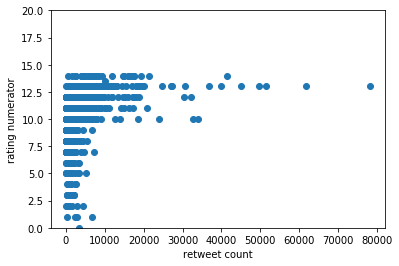

In [166]:
#plot of retweet count and rating numerator
plt.scatter(archive_clean['retweet_count'],archive_clean['rating_numerator'])
plt.ylim(0,20)
plt.xlabel('retweet count')
plt.ylabel('rating numerator')

np.corrcoef(archive_clean['retweet_count'],archive_clean['rating_numerator'])

array([[ 1.        ,  0.02295621],
       [ 0.02295621,  1.        ]])

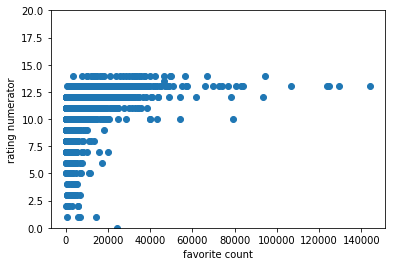

In [167]:
#plot of favorite count and rating numerator
plt.scatter(archive_clean['favorite_count'],archive_clean['rating_numerator'])
plt.ylim(0,20)
plt.xlabel('favorite count')
plt.ylabel('rating numerator')

np.corrcoef(archive_clean['favorite_count'],archive_clean['rating_numerator'])

In [168]:
#let's look at highest average rated dog breeds
dogs_only = archive_clean[archive_clean['p1_dog']==True]
dog_rate = dogs_only.groupby(by='p1').mean().sort_values('rating_numerator', ascending = False)
dog_rate.head()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog
p1,,,,,,,,,,,
clumber,27.000000,10.0,1845.000000,7216.000000,1.000000,0.946718,1.0,0.015950,1.000000,0.006519,1.000000
Pomeranian,12.868421,10.0,2821.131579,8022.000000,1.342105,0.743606,1.0,0.103489,0.894737,0.037442,0.815789
Saluki,12.500000,10.0,5042.250000,23799.750000,1.000000,0.523054,1.0,0.208351,1.000000,0.118570,1.000000
briard,12.333333,10.0,2909.333333,9379.333333,2.000000,0.618748,1.0,0.189322,1.000000,0.053280,1.000000
Tibetan_mastiff,12.250000,10.0,4106.500000,12011.250000,1.000000,0.679344,1.0,0.141119,1.000000,0.058313,1.000000


In [169]:
#there is only one dog for this data point
dogs_only[dogs_only['p1'] == 'clumber']

,timestamp,text,rating_numerator,rating_denominator,name,category,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,
778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile bac...,27.0,10.0,Sophie,pupper,1845,7216,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True,cocker_spaniel,0.01595,True,Lhasa,0.006519,True


In [170]:
#let's look at highest average retweeted dog breeds
dog_tweet = dogs_only.groupby(by='p1').mean().sort_values('retweet_count', ascending = False)
dog_tweet.head()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog
p1,,,,,,,,,,,
standard_poodle,10.285714,10.0,6511.000000,15595.571429,1.0,0.400222,1.0,0.188596,0.857143,0.072100,0.857143
English_springer,11.111111,10.0,5877.111111,15476.666667,1.0,0.546486,1.0,0.200781,1.000000,0.080672,1.000000
Afghan_hound,9.666667,10.0,5857.333333,17068.666667,1.0,0.433959,1.0,0.099034,1.000000,0.081651,0.666667
giant_schnauzer,11.500000,10.0,5051.000000,17064.500000,1.0,0.593866,1.0,0.135598,1.000000,0.071211,1.000000
Saluki,12.500000,10.0,5042.250000,23799.750000,1.0,0.523054,1.0,0.208351,1.000000,0.118570,1.000000


array([[ 1.        ,  0.20862081],
       [ 0.20862081,  1.        ]])

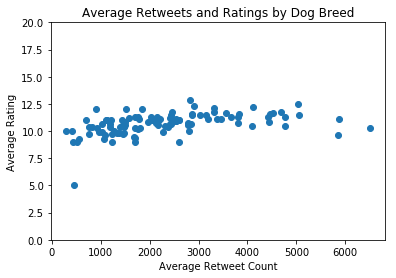

In [171]:
plt.scatter(dog_rate['retweet_count'],dog_rate['rating_numerator'])
plt.ylim(0,20)
plt.xlabel('Average Retweet Count')
plt.ylabel('Average Rating')
plt.title('Average Retweets and Ratings by Dog Breed')

np.corrcoef(dog_rate['retweet_count'],dog_rate['rating_numerator'])

#### Insights

> The most retweeted dog in the dataset is a Labrador Retriever rated 13/10 and categorized as a 'doggo', posted on June 18th, 2016, with the text, "Here's a doggo realizing you can stand in a pool. 13/10 enlightened af."

> The most favorited dog in the dataset is a Lakeland Terrier rated 13/10 and categorized as a 'puppo', posted on January 21st, 2017, with the text, "Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10."

> There doesn't appear to be much of a correlation between either retweet count or favorite count and dog rating.

> On average, a clumber breed of dog is the highest rated but there is only one data point for that. So a more fair claim would be that on average, a Pomeranian is the highest rated dog breed.

> On average, a standard poodle is the most retweeted dog.